In [65]:
import os
import numpy as np
import operator
import matplotlib.pyplot as plt
from primed_data_processing.cellbuilder import CellBuilder
from primed_data_processing.arbin_cycler import ArbinCell

# Import Data

In [2]:
# instantiate CellBuilder
cell_builder = CellBuilder()

# raws_prepath = 'path/to/raws/'
raws_prepath = 'C:/Users/seanb/OneDrive/Documents/PRIMED/export/batdat/MTC/raws/'

# all channel and cell numbers from B6 in order
channel_numbers = (1,2,3,4,9,10,11,12,13,14,15,16)
cell_numbers = (9,10,11,12,1,2,3,4,5,6,7,8)

# list for holding processed cells
arbin_cells = []

# loop over channel numbers
for channel_idx, channel in enumerate(channel_numbers):
    print(f'Processing channel {channel}')

    # make subfolder name in raws folder
    folder_name = f'B6T10V0_1_2_3_4_9_10_11_12_13_14_15_16/Channel_{channel}/'

    # append new cell to cells processed cells list
    arbin_cells.append(ArbinCell(cell_numbers[channel_idx], channel))

    # get directory of the current folder
    directory = os.fsencode(raws_prepath+folder_name)

    # loop over all files in the current directory
    for file in os.listdir(directory):
        # get filename
        filename = os.fsdecode(file)

        # ignore .xlsx files
        if filename.endswith('.csv'):
            # process file with CellBuilder method
            cell_builder.read_B6_csv_data(
                arbin_cells[channel_idx], # current cell being processed
                raws_prepath+folder_name+filename, # path to file being processed
                {'characterization': [6,10]}, # get OCV charge and discharg steps
                verbose=False # minimal printouts
            )

Processing channel 1
Processing channel 2
Processing channel 3
Processing channel 4
Processing channel 9
Processing channel 10
Processing channel 11
Processing channel 12
Processing channel 13
Processing channel 14
Processing channel 15
Processing channel 16


# Data Processing

In [140]:
def step_gen(step):
    for cells in arbin_cells:
        for cycle in cells:
            if cycle.get_step(step):
                yield cycle.get_step(step)[0]

def assign_soh(step, nom_cap):
    for cell in arbin_cells:
        for cycle in cell:
            if cycle.get_step(step):
                if cycle.get_step(10):
                    soh = cycle.get_step(10)[0]['Discharge_Capacity(Ah)'][-1]/nom_cap
                    cycle.get_step(step)[0].soh = soh
                    cycle.get_step(step)[0].cell_number = cell.cell_number
                    cycle.get_step(step)[0].channel_number = cell.channel_number
                else:
                    cycle.get_step(step)[0].soh = -1

def filter_by_soh(steps, soh_range):
    soh_filtered = {}
    for lower in range(77, 101, soh_range):
        upper = (lower + soh_range)/100
        lower = lower/100
        soh_filtered[lower] = list(
            filter(lambda x: (lower < x.soh < upper), steps)
            )
    return soh_filtered

# Plotting Functions

In [239]:
def plot_ocv(step, feature, nom_cap):
    plt.plot(np.array(step[feature])/nom_cap, step['Voltage(V)'])
    plt.xlabel('SOC')
    plt.ylabel('Voltage')
    plt.xlim(0,1)

def plot_ocvs(steps, feature, nom_cap):
    plt.figure()
    for step in steps:
        plt.plot(np.array(step[feature])/nom_cap, step['Voltage(V)'], label=f"{step.soh} {step.channel_number}")
    plt.xlabel('SOC')
    plt.ylabel('Voltage')
    plt.xlim(0,1)
    plt.legend()

def plot_ocv_array(filtered_steps, feature, nom_cap):
    nrows = int(len(filtered_steps.keys()) / 3)
    ncols = 3

    col_labels = [f"SOC" for j in range(ncols)]

    for i, key in enumerate(filtered_steps.keys()):
        if i % ncols == 0:
            fig, ax = plt.subplots(1, ncols, sharey='row', figsize=(15, 9))

            for ax_col, col_label in zip(ax, col_labels):
                ax_col.annotate(col_label, xy=(0.5, 1.1), xycoords='axes fraction',
                                ha='center', va='center', fontsize=12)

        col = i % ncols

        for step in filtered_steps[key]:
            ax[col].plot(np.array(step[feature]) / nom_cap, step['Voltage(V)'],
                         label=f"SOH: {round(step.soh, 2)} Chan: {step.channel_number}")

        if i % ncols == 2:
            ax[0].set_ylabel("Voltage (V)")
            for ax in fig.axes:
                ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

            plt.tight_layout()
    plt.show()
    
    

In [141]:
# calculate and assing SOH's to all of the steps
assign_soh(6,4)
assign_soh(10,4)

# collect step data
step6 = list(step_gen(6))
step10 = list(step_gen(10))

# filter into bins of 1% soh
step6_filtered = filter_by_soh(step6, 1)
step10_filtered = filter_by_soh(step10, 1)

# Inspect OCV Curves

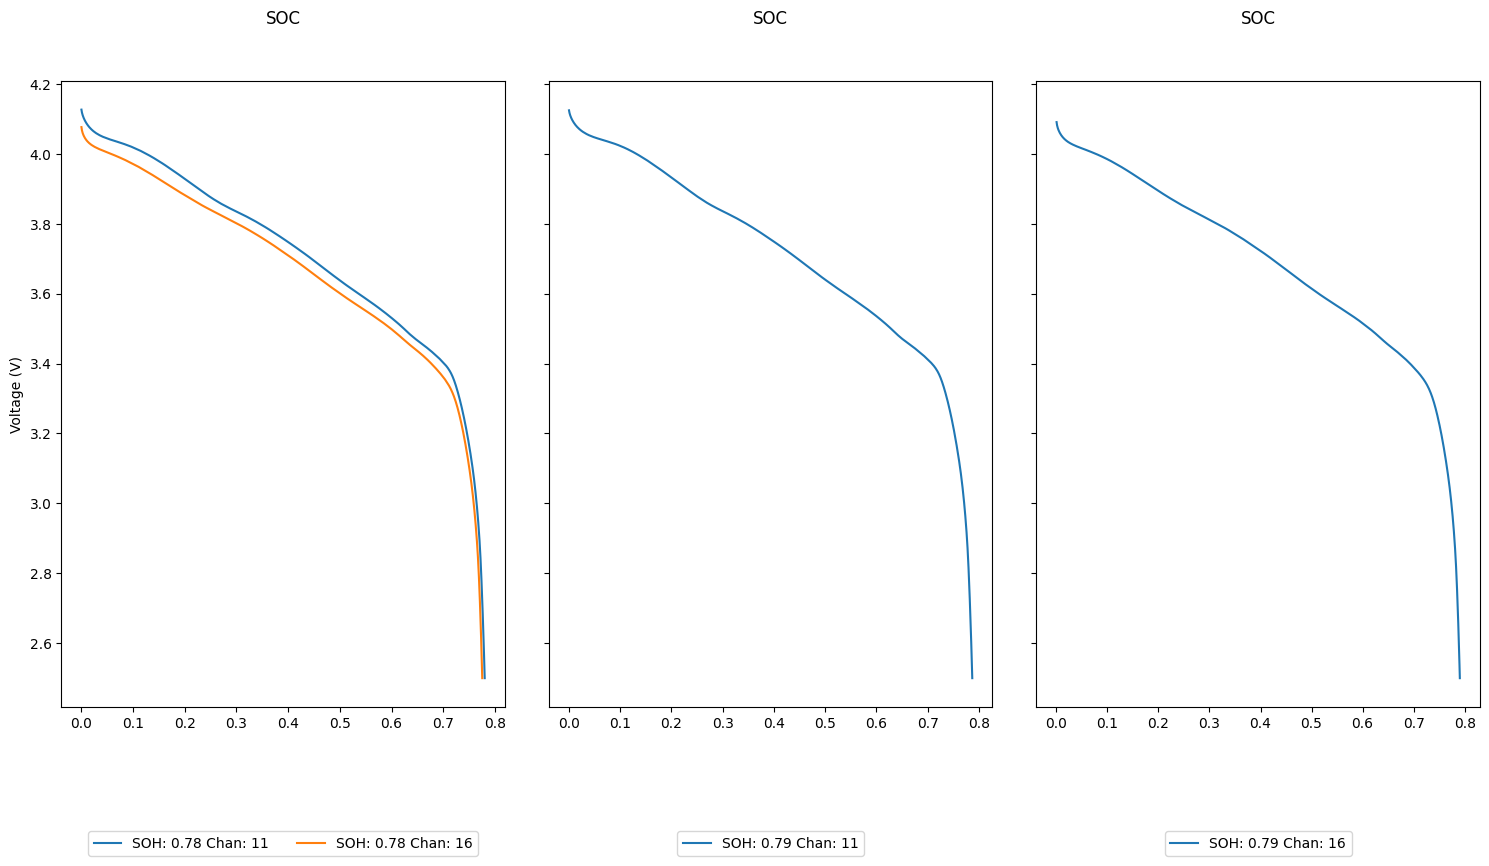

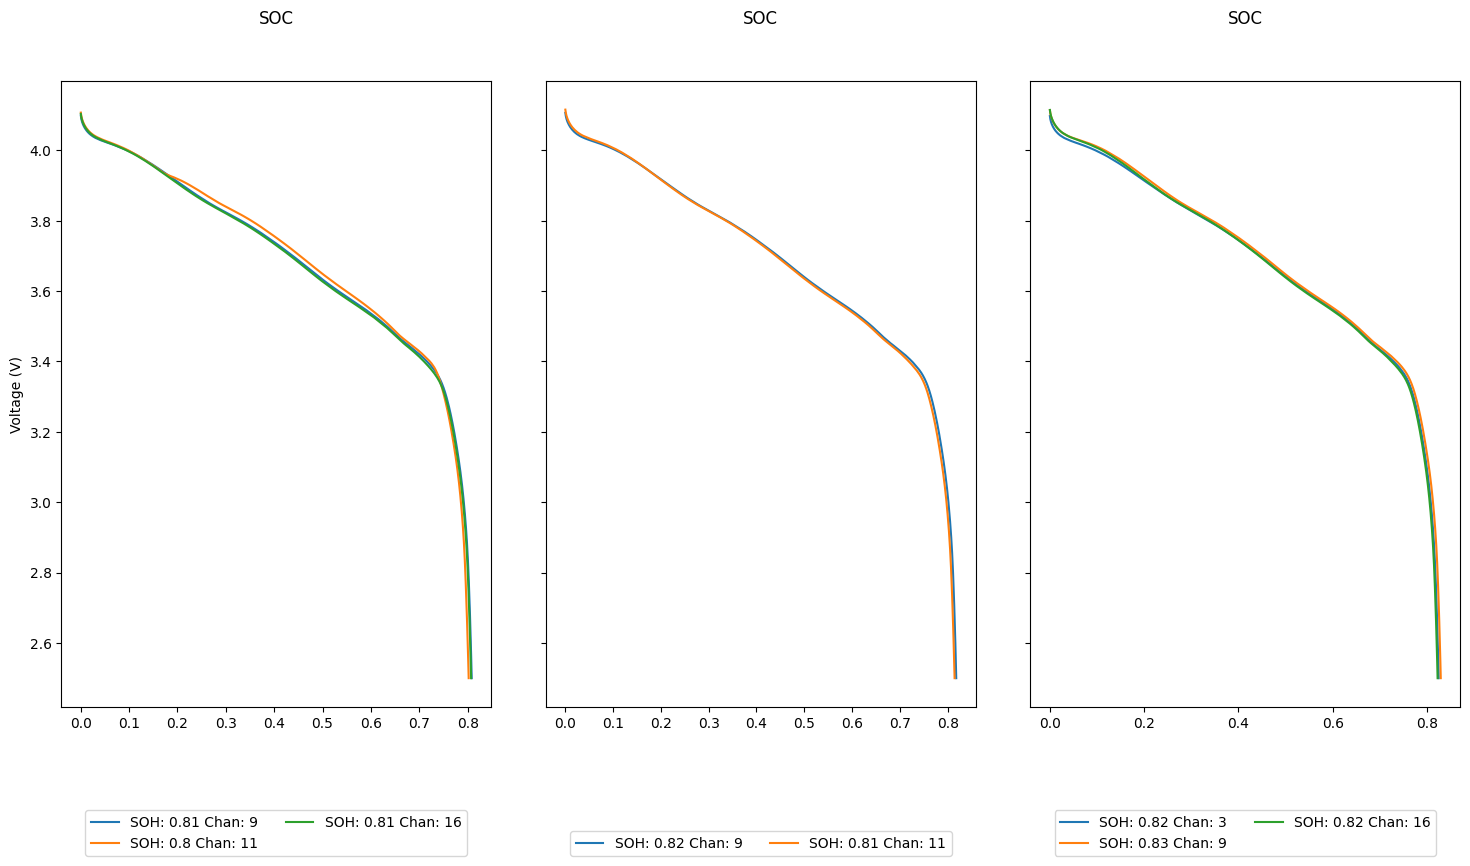

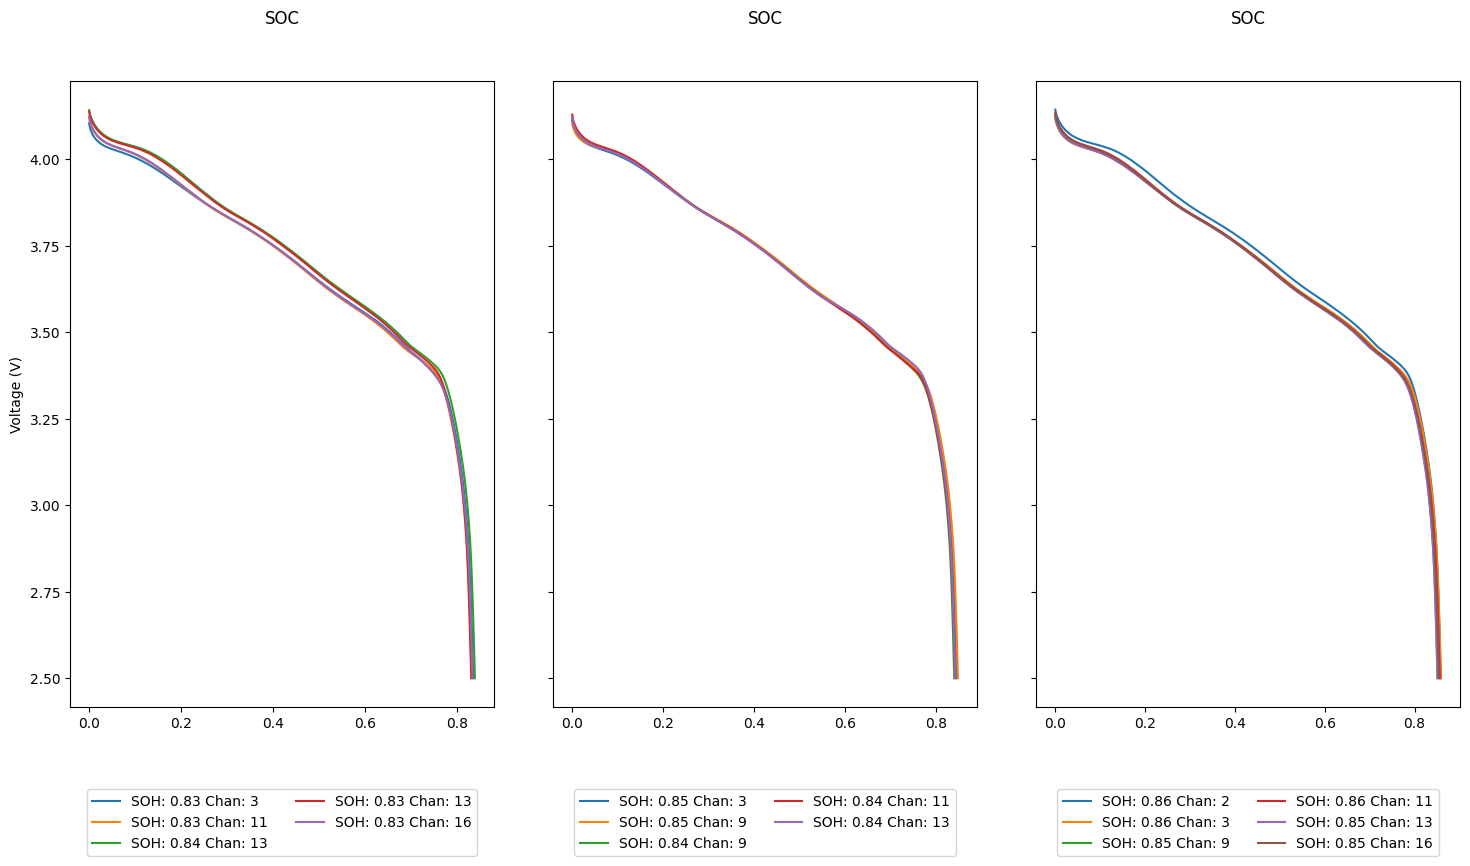

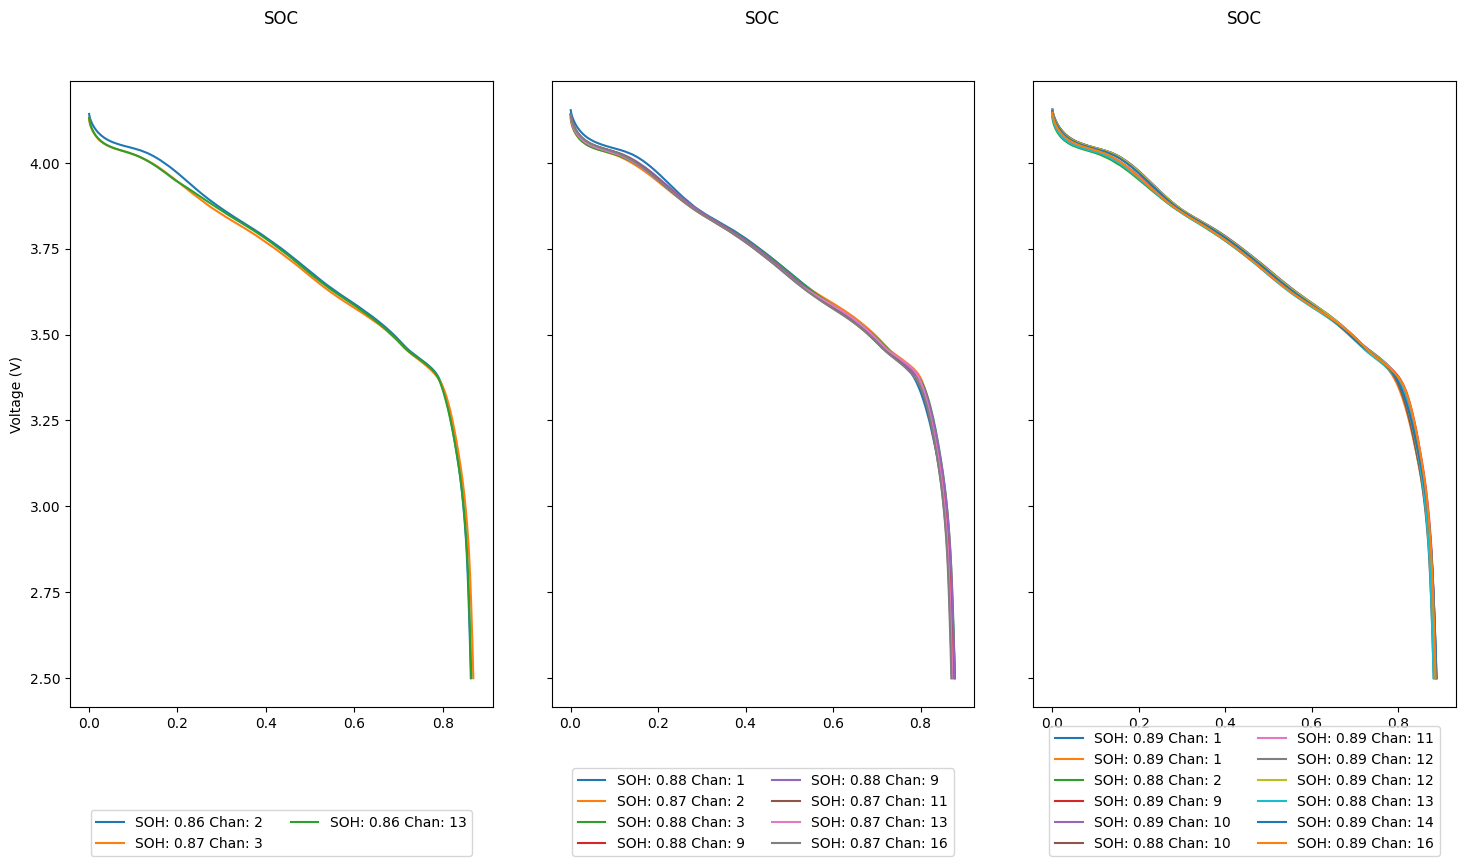

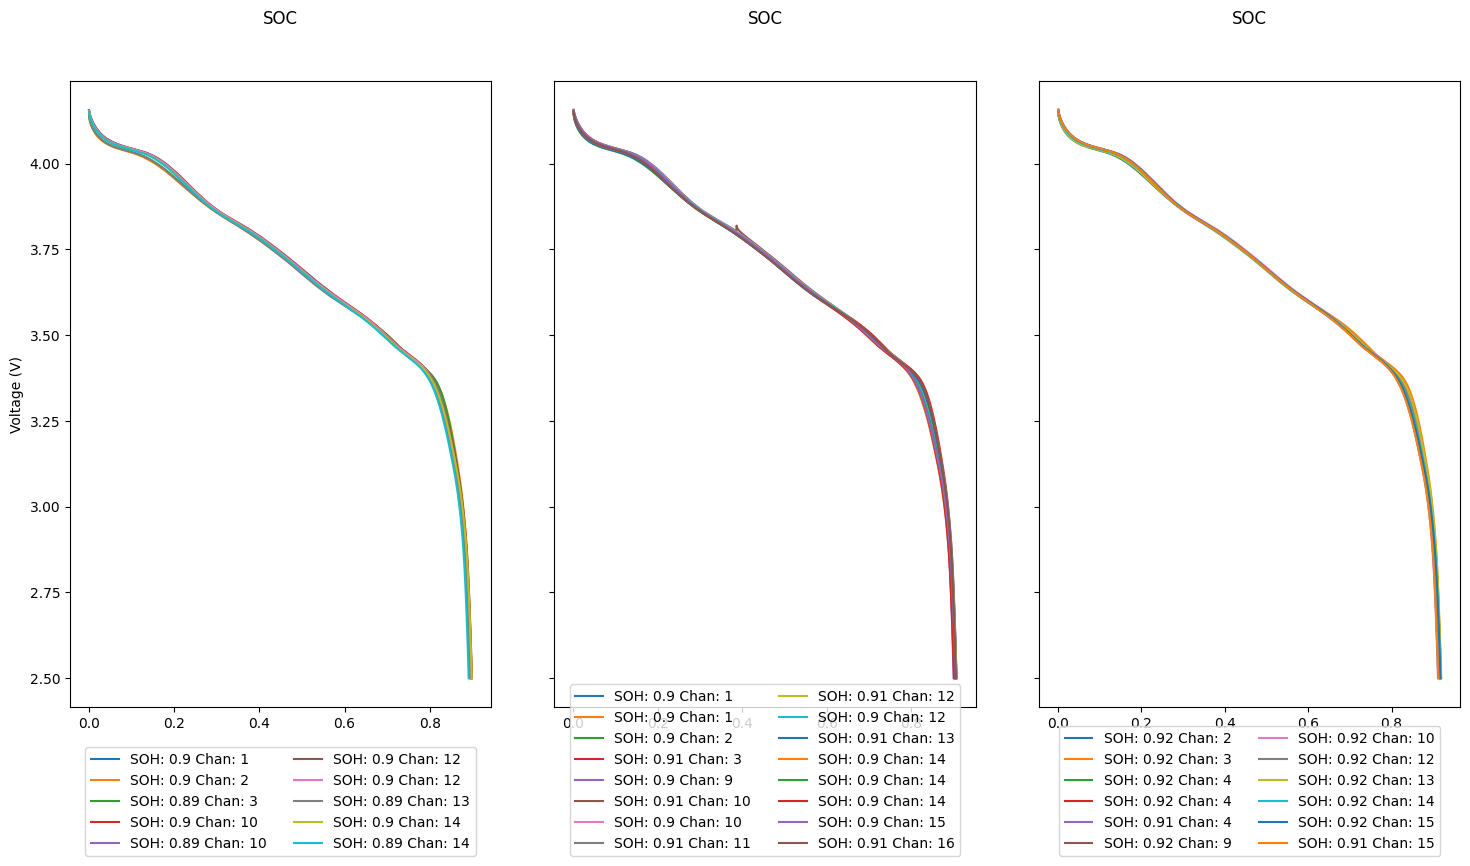

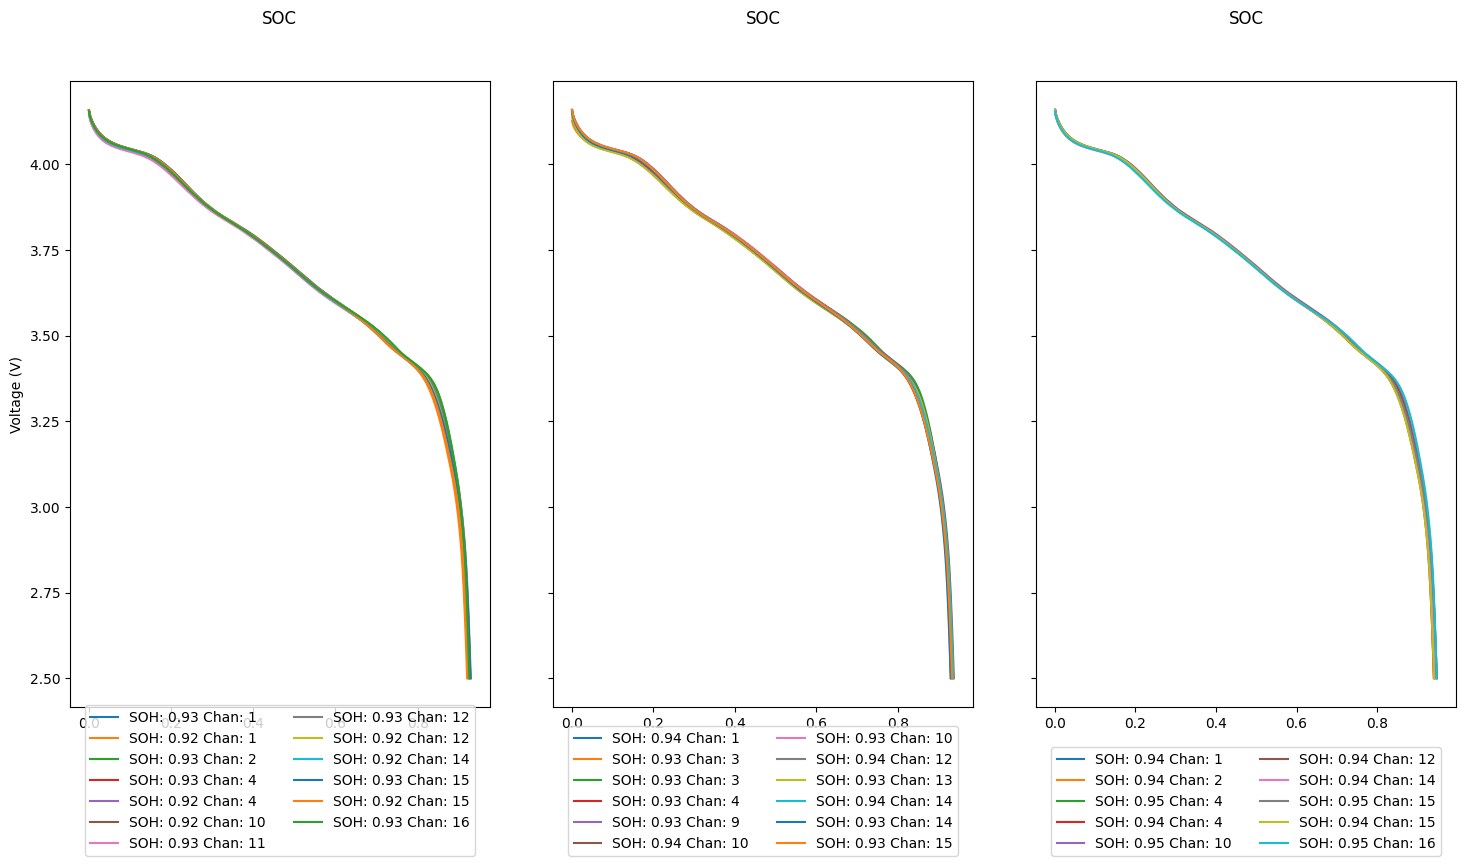

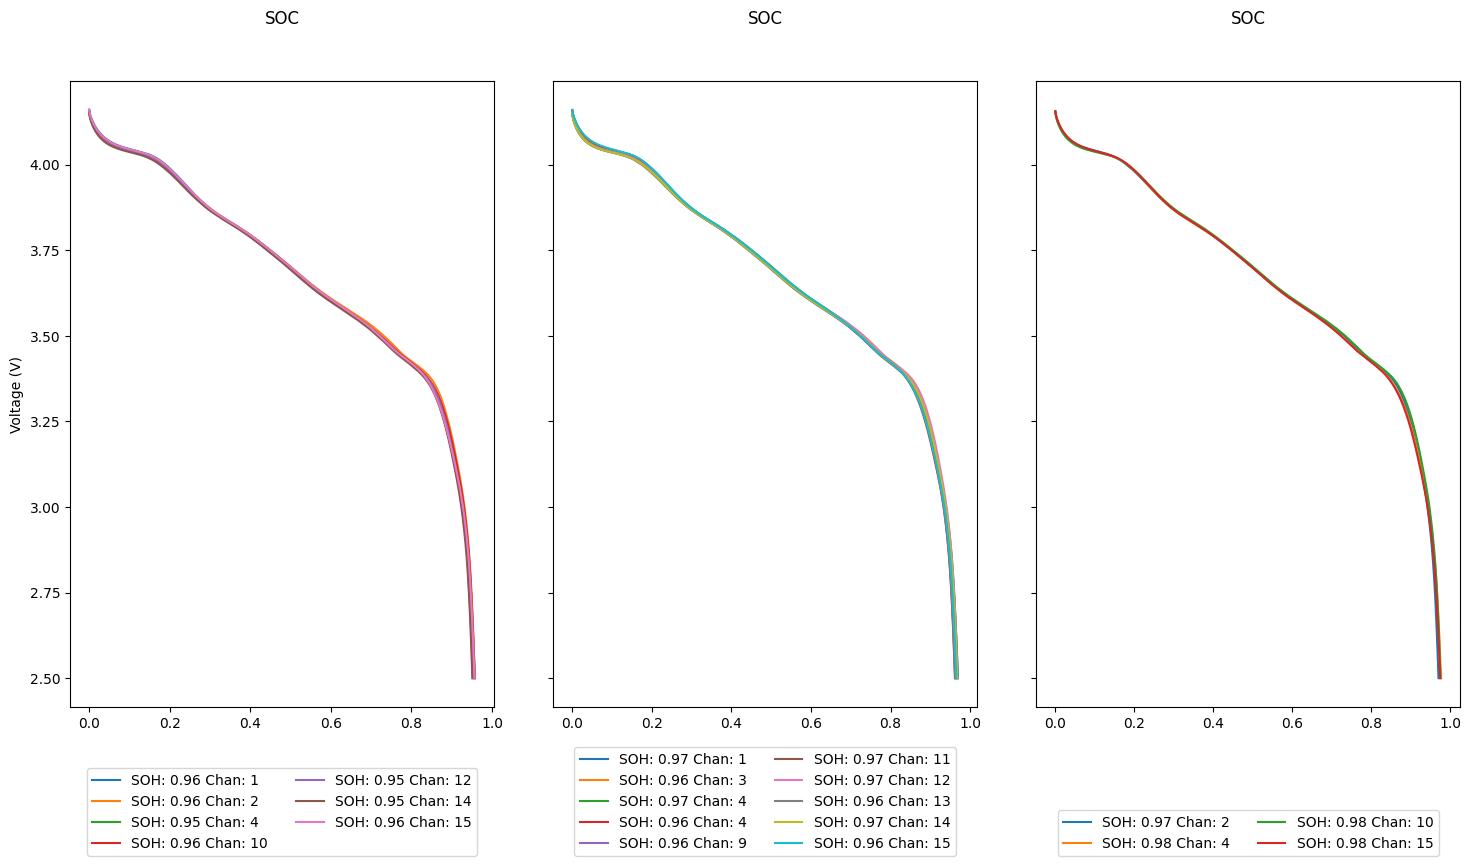

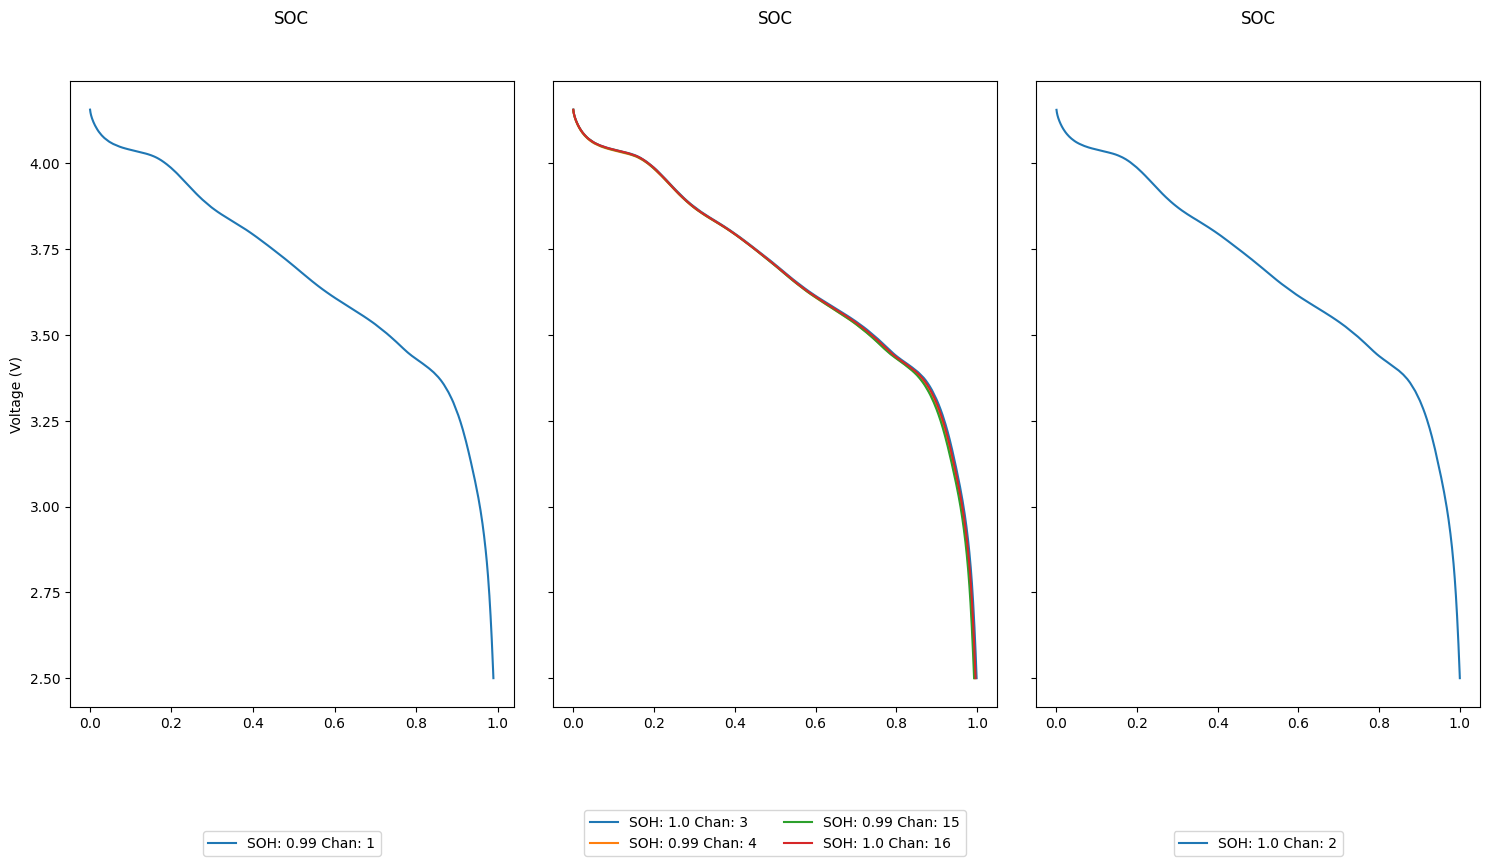

In [240]:
plot_ocv_array(step10_filtered,"Discharge_Capacity(Ah)",4)

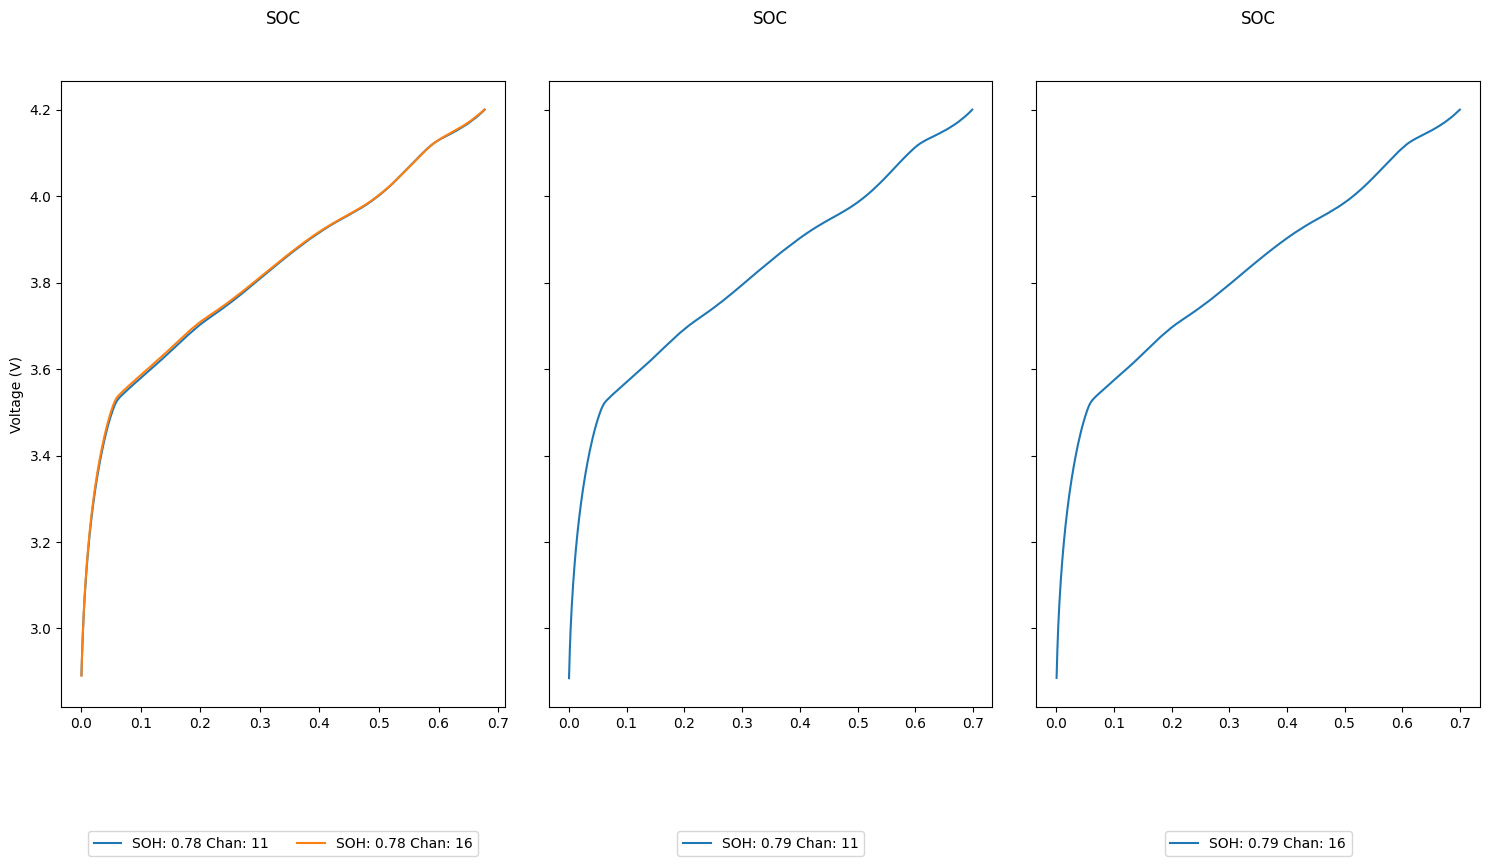

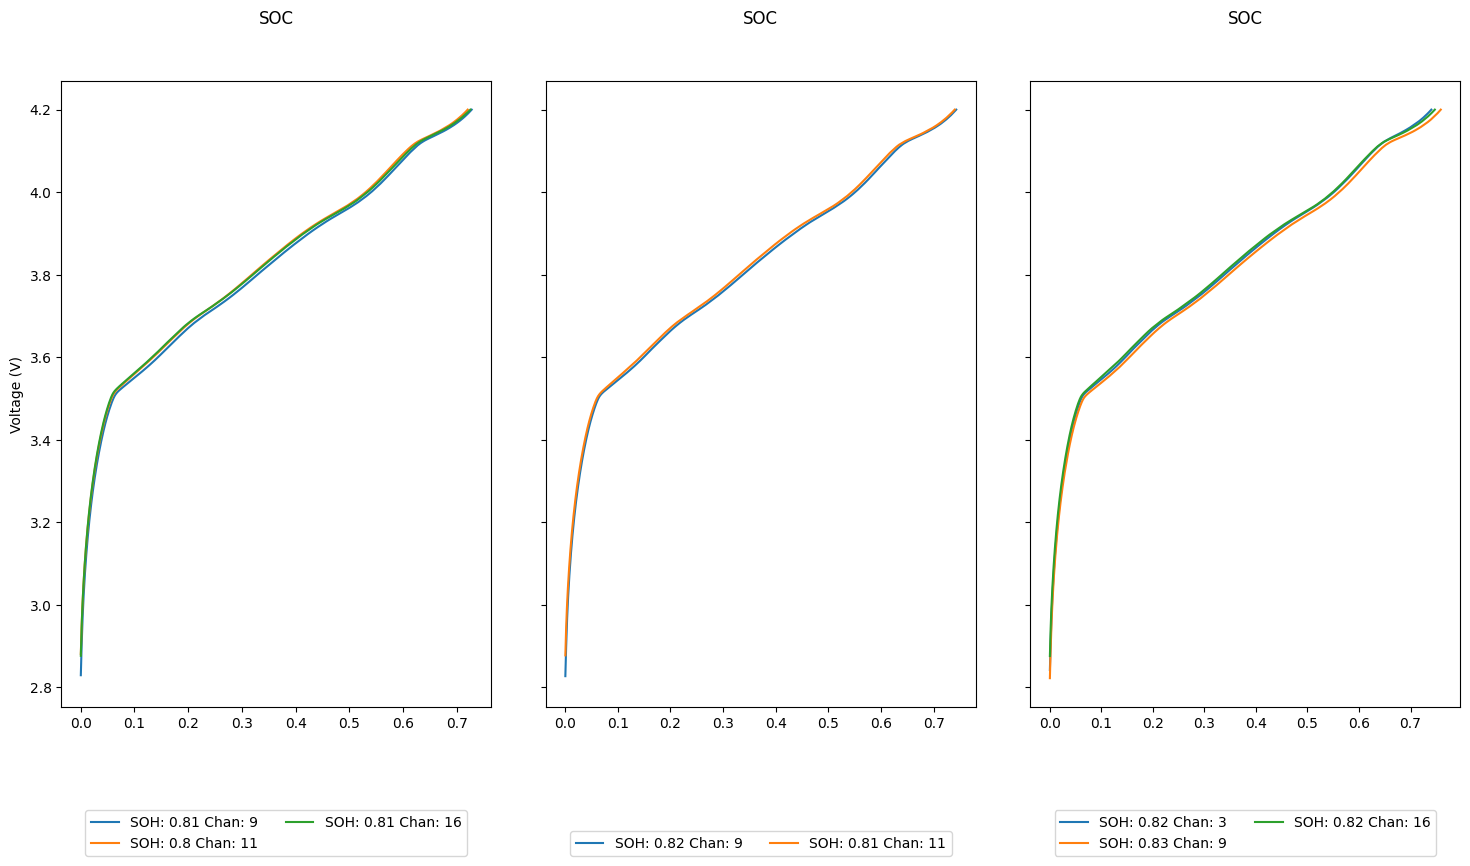

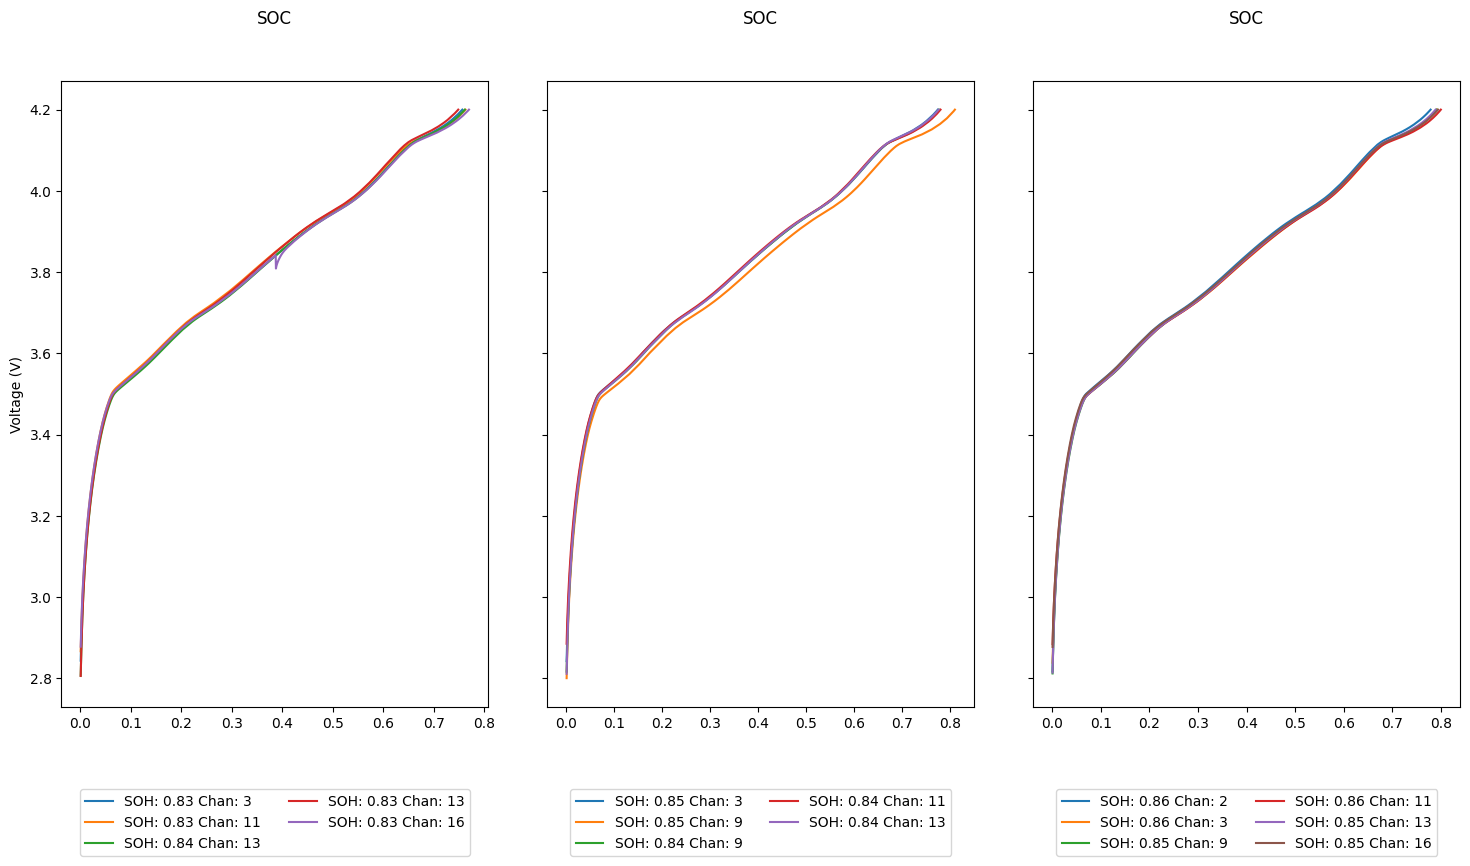

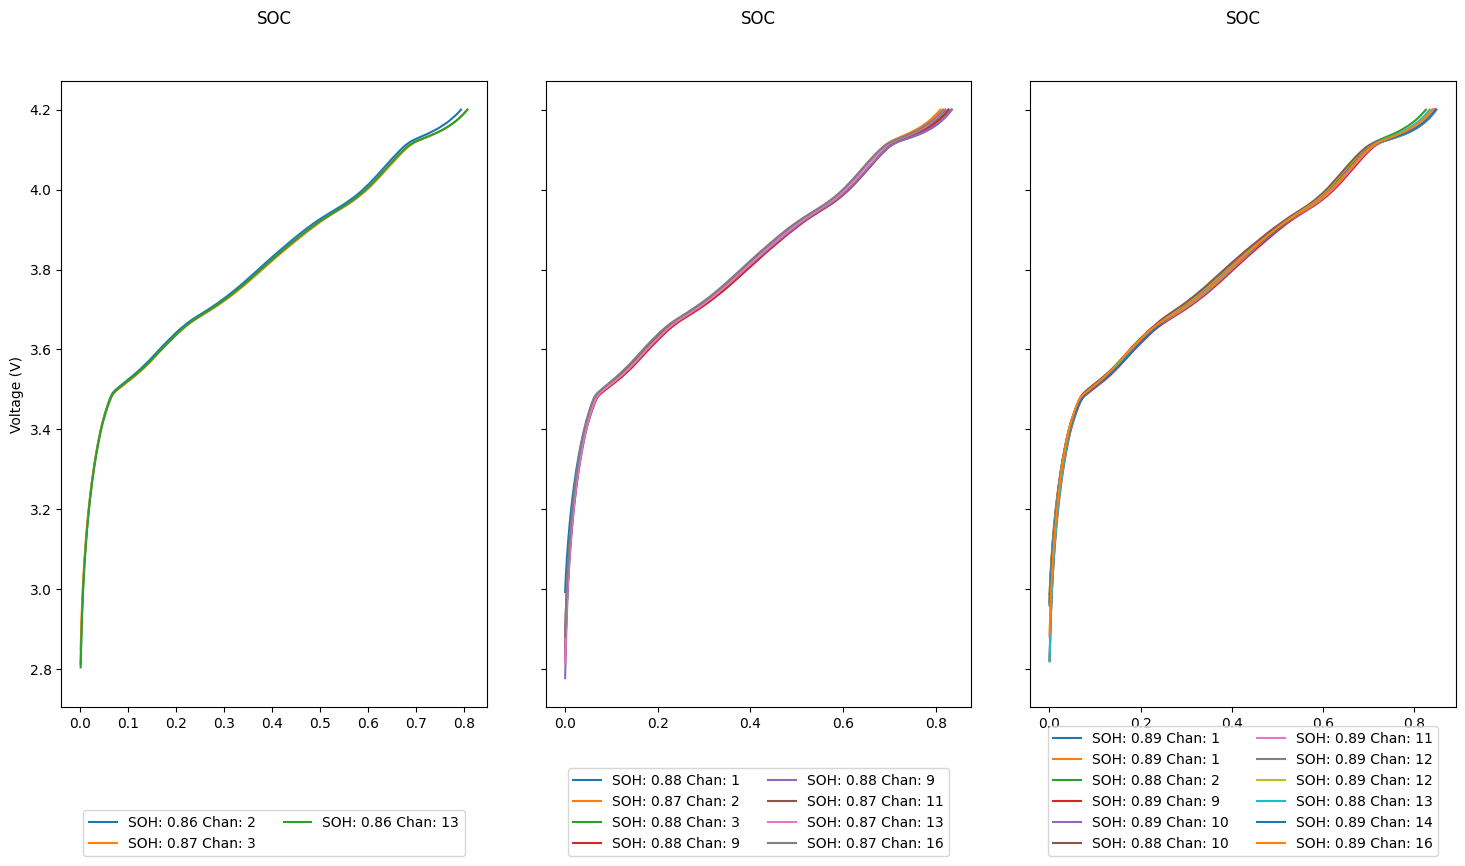

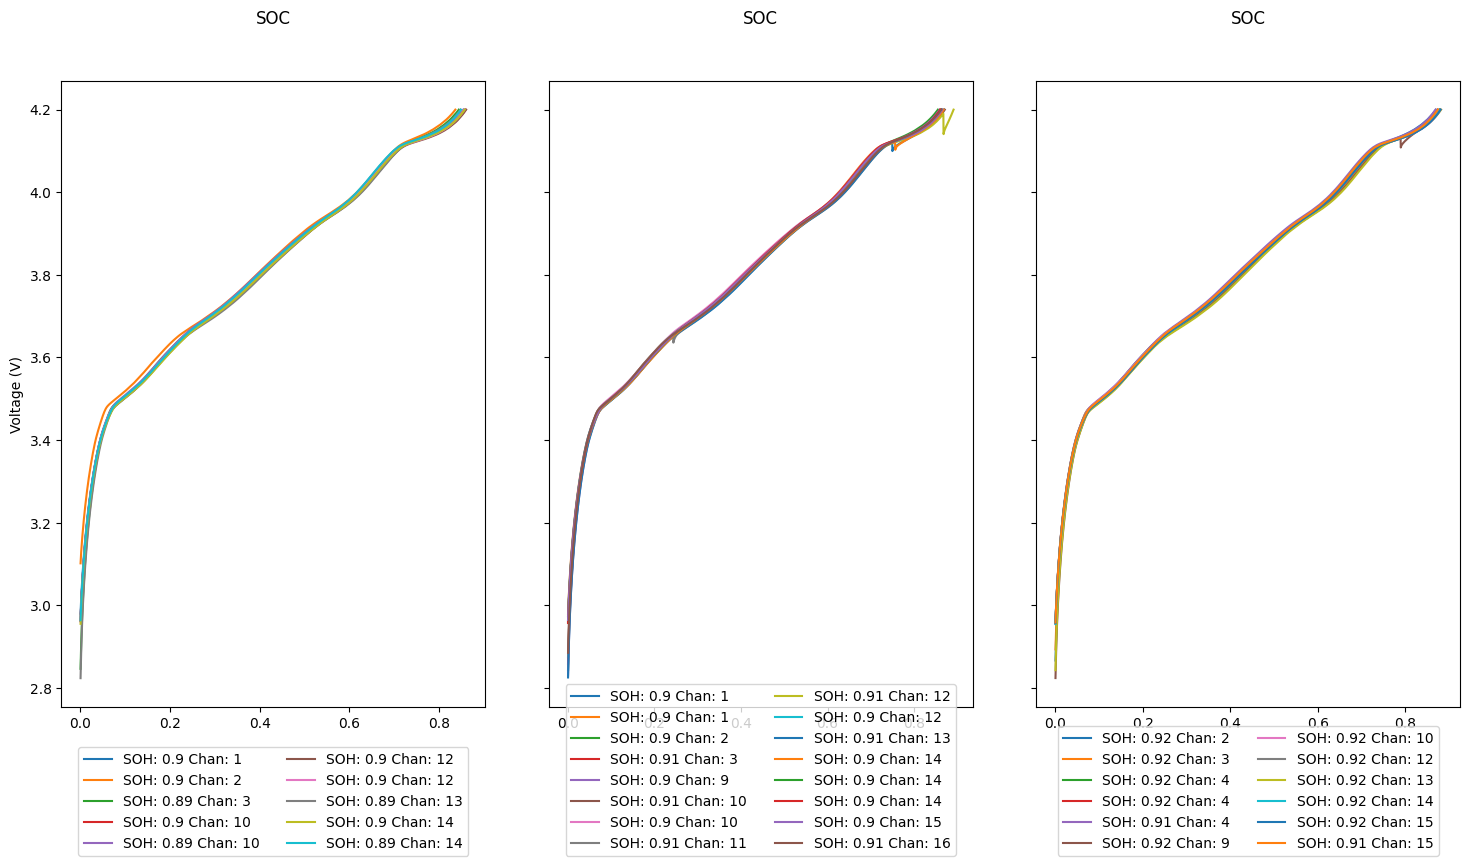

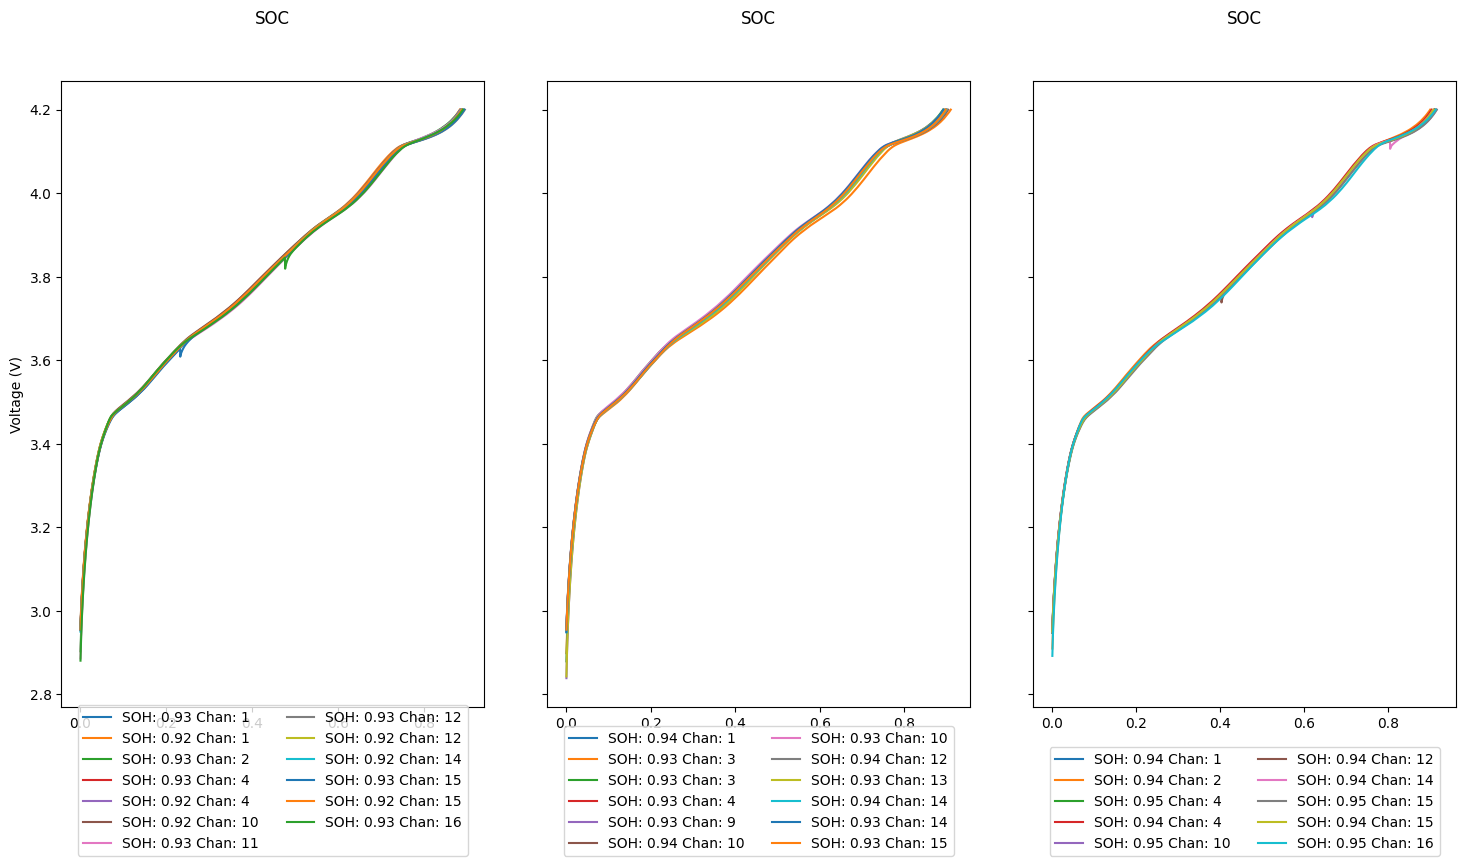

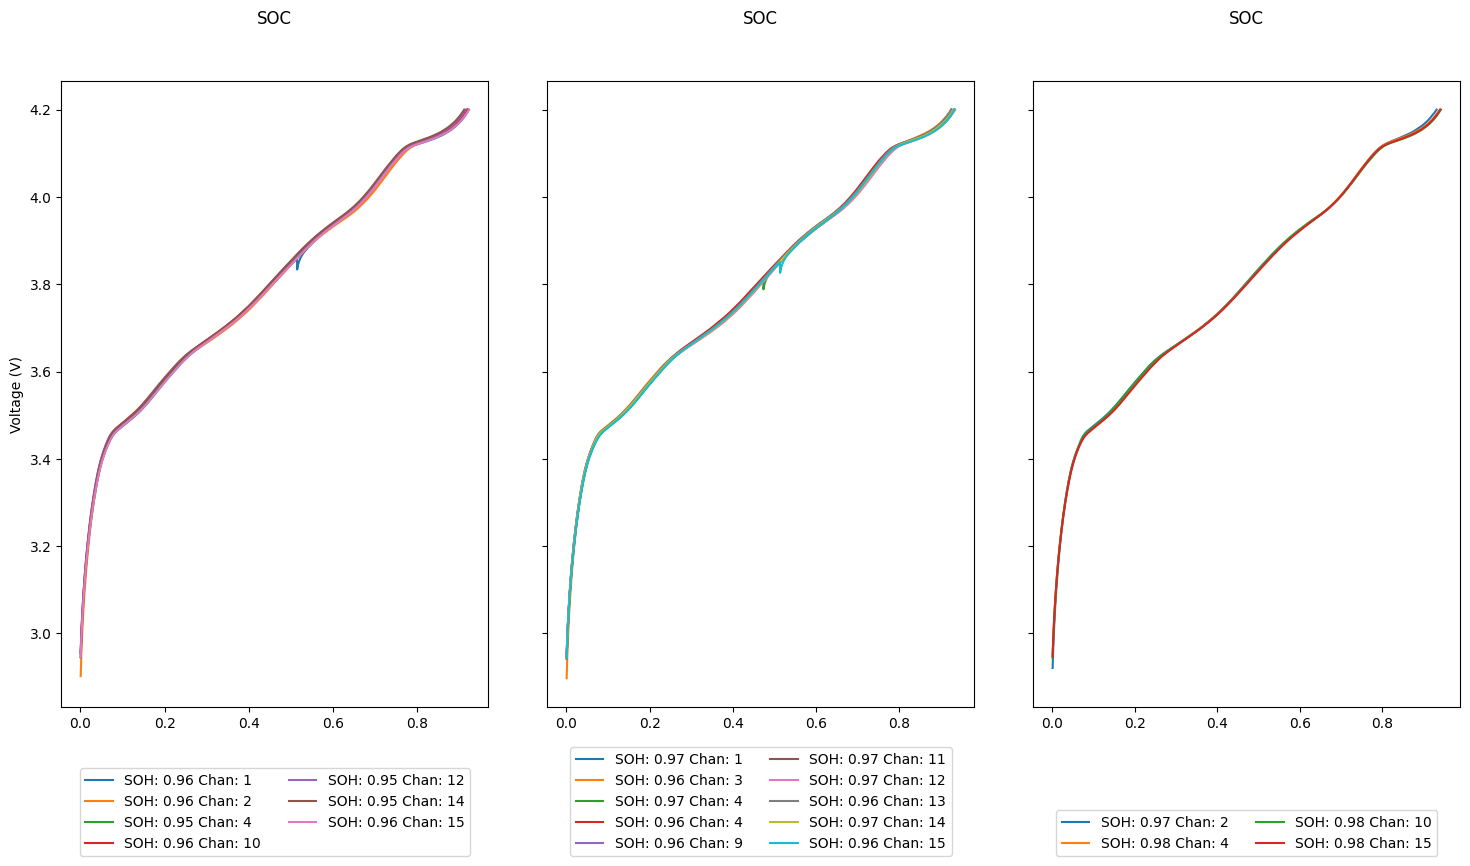

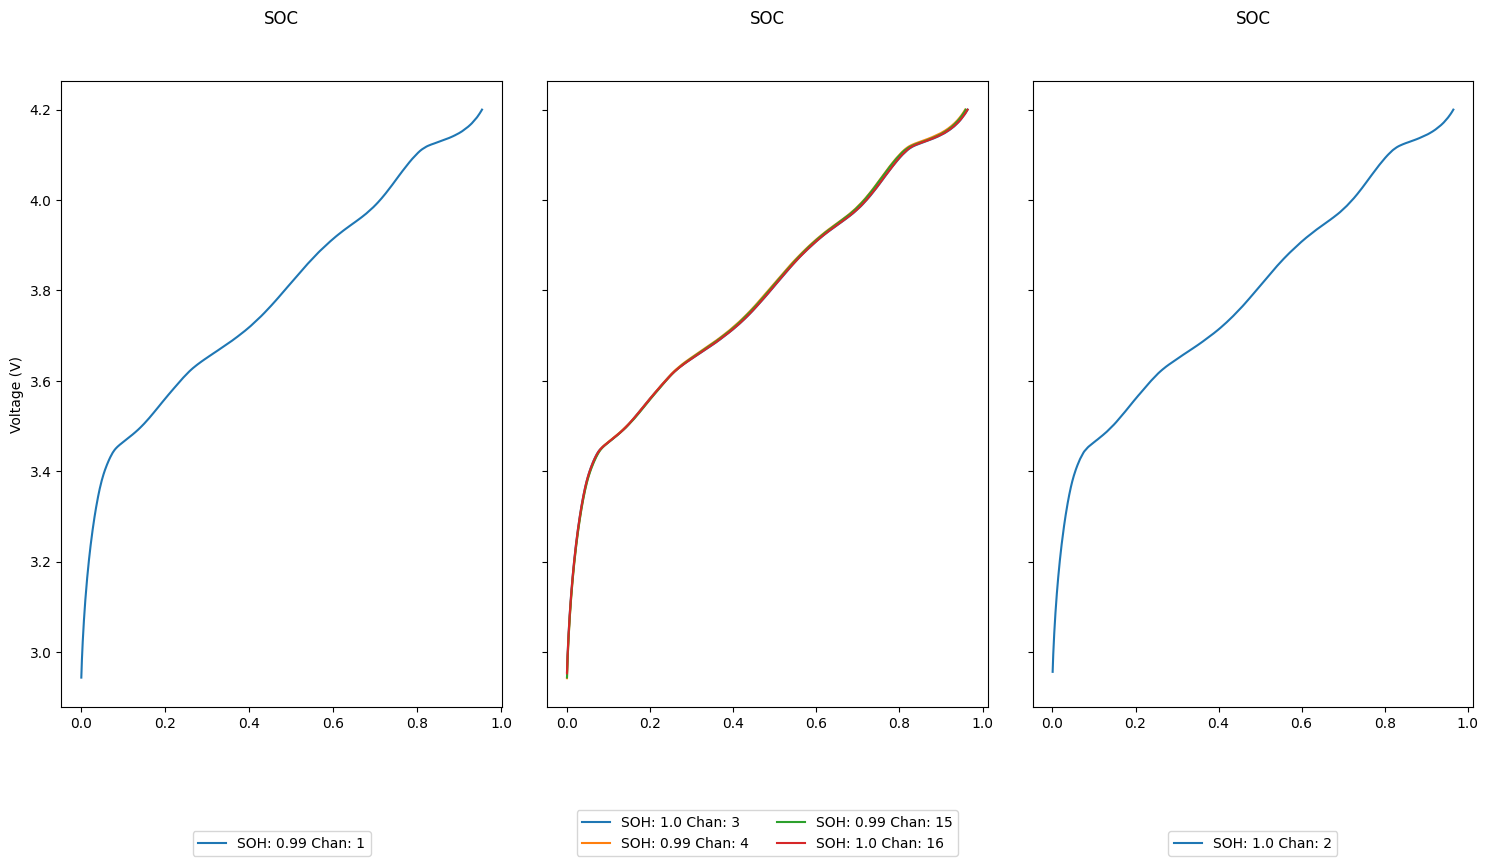

In [241]:
plot_ocv_array(step6_filtered,"Charge_Capacity(Ah)",4)